# Projekt

**Tema**  
Usporedba alata za označavanje teksta

**Studij**  
Preddiplomski studij informatike

# Uvod

U ovom notebooku biti će prikazani svi eksperimenti koji su se provodili da bi se došlo do konačnog rezultata. Detaljnija objašnjenja pojedinih koraka i vizualizacije podataka mogu se pronaći u drugom notebooku (finalnoj verziji).

# Preuzimanje i priprema podataka

Podatke preuzimamo sa stranice https://deepai.org/dataset/conll-2003-english. Na stranici se nalazi naredba koju moramo pokrenuti unutar Colab-a da bi se podaci preuzeli.

In [ ]:
!wget https://data.deepai.org/conll2003.zip

--2022-06-10 13:08:55--  https://data.deepai.org/conll2003.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982975 (960K) [application/x-zip-compressed]
Saving to: ‘conll2003.zip.2’

conll2003.zip.2     100%[===================>] 959.94K  --.-KB/s    in 0.07s   

2022-06-10 13:08:55 (14.0 MB/s) - ‘conll2003.zip.2’ saved [982975/982975]



In [ ]:
# Raspakiravanje podataka
import zipfile
zip_ref = zipfile.ZipFile("conll2003.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Dohvaćanje linija teksta iz .txt datoteka
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

train = get_lines("train.txt")
valid = get_lines("valid.txt")
test = get_lines("test.txt")

In [ ]:
train[:5]

['-DOCSTART- -X- -X- O\n',
 '\n',
 'EU NNP B-NP B-ORG\n',
 'rejects VBZ B-VP O\n',
 'German JJ B-NP B-MISC\n']

In [ ]:
# Funkcija za obradu linija teksta koje smo dobili pomoću prethodne funkcije

def preprocess_text (text):
  
  preprocessed_lines = []
  sentence_num = -1

  for line in text:
    if line.startswith("-DOCSTART-"):
      pass
    elif line == "\n":
      sentence_num += 1
    else:
      line_data = {}
      line_split = line.split()
      line_data["word"] = line_split[0]
      line_data["label"] = line_split[-1]
      line_data["sentence_num"] = sentence_num
      preprocessed_lines.append(line_data)
  
  return preprocessed_lines

preprocessed_train = preprocess_text(train)
preprocessed_valid = preprocess_text(valid)
preprocessed_test = preprocess_text(test)

In [ ]:
preprocessed_train[0]

{'label': 'B-ORG', 'sentence_num': 0, 'word': 'EU'}

## Kreiranje DataFrameova

In [ ]:
import pandas as pd
train_df = pd.DataFrame(preprocessed_train)
val_df = pd.DataFrame(preprocessed_valid)
test_df = pd.DataFrame(preprocessed_test)
train_df.head(15)

,word,label,sentence_num
0,EU,B-ORG,0
1,rejects,O,0
2,German,B-MISC,0
3,call,O,0
4,to,O,0
5,boycott,O,0
6,British,B-MISC,0
7,lamb,O,0
8,.,O,0
9,Peter,B-PER,1


## Kreiranje liste rečenica

In [ ]:
def get_sentences_list_from_df (df):

  sentences = []
  sentence = ""

  for index, row in df.iterrows():
    if index == 0:
      sentence += row["word"]
    elif row["sentence_num"] == df.iloc[index - 1]["sentence_num"]:
      sentence += " " + row["word"]
    else:
      sentences.append(sentence)
      sentence = ""
      sentence += row["word"]
    
  return sentences

In [ ]:
train_sentences_list = get_sentences_list_from_df(train_df)
val_sentences_list = get_sentences_list_from_df(val_df)
test_sentences_list = get_sentences_list_from_df(test_df)

## Duljina rečenica

Trebamo odrediti koliko će nam biti dugi ulazni podaci. Sve rečenice koje ulaze u naš model trebaju biti iste duljine. Izračunati ćemo 95. percentil (duljinu koju ima barem 95% svih rečenica) te uzeti tu vrijednost za duljinu ulaznih podataka.



In [ ]:
import numpy as np

sent_lens = []

for sent in train_sentences_list:
  sent_lens.append(len(sent.split()))

len_percentile = int(np.percentile(sent_lens, 95))
len_percentile

37

## Vektorizacija teksta

In [ ]:
words = list(set(train_df["word"].values))
num_words = len(words)

print(f"Broj jedinstvenih riječi: {num_words}")

Broj jedinstvenih riječi: 23623


In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=23000,
                                    output_sequence_length=len_percentile) # koristimo vrijednost koju smo dobili gore

In [ ]:
text_vectorizer.adapt(train_sentences_list)

In [ ]:
# Vektorizacija svih rečenica
train_sentences_vectorized = [text_vectorizer([x]) for x in train_sentences_list]
val_sentences_vectorized = [text_vectorizer([x]) for x in val_sentences_list]
test_sentences_vectorized = [text_vectorizer([x]) for x in test_sentences_list]

## Numeriranje i popunjavanje (*padding*) oznaka

In [ ]:
labels = list(set(train_df["label"].values))

label2idx = {t: i for i, t in enumerate(labels)}
idx2label = {value: key for (key, value) in label2idx.items()}

In [ ]:
def tokenize_labels (df):

  labels = list(df["label"].values)
  sentence_numbers = list(df["sentence_num"].values)

  current_sentence_labels = []
  all_labels = []

  for index, el in enumerate(labels):
    if index == 0 or sentence_numbers[index] == sentence_numbers[index-1]:
      current_sentence_labels.append(el)
    else:
      all_labels.append(current_sentence_labels)
      current_sentence_labels = []
      current_sentence_labels.append(el)

  tokenized_labels = [[label2idx[label] for label in sentence] for sentence in all_labels]

  return tokenized_labels

In [ ]:
train_labels_tokenized = tokenize_labels(train_df)
val_labels_tokenized = tokenize_labels(val_df)
test_labels_tokenized = tokenize_labels(test_df)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_labels_padded = pad_sequences(maxlen=len_percentile,
                                    sequences=train_labels_tokenized,
                                    padding="post",
                                    value=label2idx["O"])

val_labels_padded = pad_sequences(maxlen=len_percentile,
                                  sequences=val_labels_tokenized,
                                  padding="post",
                                  value=label2idx["O"])

test_labels_padded = pad_sequences(maxlen=len_percentile,
                                   sequences=test_labels_tokenized,
                                   padding="post",
                                   value=label2idx["O"])

## Dovođenje podataka u isti oblik

Rečenice su nam trenutno tip podatka Tensor oblika (1, 37), dok su oznake NumPy array oblika (37,).

Možemo pokušati trenirati na jednom i drugom tipu podatka i usporediti rezultate.

### NumPy array

In [ ]:
# Primjer vektorizirane rečenice
train_sentences_vectorized[0]

<tf.Tensor: shape=(1, 37), dtype=int64, numpy=
array([[  996, 12747,   203,   618,     5,  4445,   212,  6495,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [ ]:
# Primjer popunjene oznake
train_labels_padded[0], train_labels_padded[0].shape

(array([2, 8, 0, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int32), (37,))

In [ ]:
# Pretvaranje rečenica u NumPy arrayove
import numpy as np
train_sentences_arrays = [np.array(t) for t in train_sentences_vectorized]
val_sentences_arrays = [np.array(t) for t in val_sentences_vectorized]
test_sentences_arrays = [np.array(t) for t in test_sentences_vectorized]

In [ ]:
# Smanjivanje dimenzionalosti rečenica - iz (1, 37) u (37,)
train_sentences_arrays_squeezed = np.squeeze(train_sentences_arrays)
val_sentences_arrays_squeezed = np.squeeze(val_sentences_arrays)
test_sentences_arrays_squeezed = np.squeeze(test_sentences_arrays)

In [ ]:
type(train_sentences_arrays_squeezed[0]), type(train_labels_padded[0])

(numpy.ndarray, numpy.ndarray)

In [ ]:
print(f"Oblik rečenica (tipa NumPy array): {train_sentences_arrays_squeezed.shape}")
print(f"Oblik oznaka (tipa NumPy array): {train_labels_padded.shape}")

Oblik rečenica (tipa NumPy array): (14040, 37)
Oblik oznaka (tipa NumPy array): (14040, 37)


### Tensor

In [ ]:
# EKSPERIMENT: umjesto pretvaranja rečenica u NumPy array, pretvorimo oznake u Tensor
import tensorflow as tf

train_label_tensors = tf.convert_to_tensor(train_labels_padded)
val_label_tensors = tf.convert_to_tensor(val_labels_padded)
test_label_tensors = tf.convert_to_tensor(test_labels_padded)

train_sentences_arrays_squeezed_tensors = tf.squeeze(train_sentences_vectorized)
val_sentences_arrays_squeezed_tensors = tf.squeeze(val_sentences_vectorized)
test_sentences_arrays_squeezed_tensors = tf.squeeze(test_sentences_vectorized)

In [ ]:
type(train_sentences_arrays_squeezed_tensors), type(train_label_tensors[0])

(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

In [ ]:
print(f"Oblik rečenica (tipa Tensor): {train_sentences_arrays_squeezed_tensors.shape}")
print(f"Oblik oznaka (tipa Tensor): {train_label_tensors.shape}")

Oblik rečenica (tipa Tensor): (14040, 37)
Oblik oznaka (tipa Tensor): (14040, 37)


In [ ]:
# Pomoćna funkcija za prikaz tijeka treniranja
import matplotlib.pyplot as plt

def plot_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']


  epoch = range(1, len(acc) + 1)

  plt.plot(epoch, loss, 'r', label = 'Gubitak (trening)')
  plt.plot(epoch, val_loss, 'b', label = 'Gubitak (validacija)')
  plt.title('Vrijednost funkcije gubitka na skupu za treniranje i skupu za validaciju')
  plt.xlabel('Epoha')
  plt.ylabel('Gubitak')
  plt.legend()
  plt.show()

  plt.plot(epoch, acc, 'r', label = 'Točnost (trening)')
  plt.plot(epoch, val_acc, 'b', label = 'Točnost (validacija)')
  plt.title('Točnost na skupu za treniranje i skupu za validaciju')
  plt.xlabel('Epoha')
  plt.ylabel('Točnost')
  plt.legend()
  plt.show()

In [ ]:
# Trenirati ćemo na 50% podatka radi bržeg treniranja modela
from sklearn.model_selection import train_test_split

# NumPy arrayevi
X_train, data_50_percent_array, y_train, labels_50_percent_array = train_test_split(train_sentences_arrays_squeezed,
                                                                                    train_labels_padded,
                                                                                    test_size=0.5,
                                                                                    random_state=42)

# Tenzori
length = int(len(train_sentences_arrays_squeezed_tensors) * 0.5)
data_50_percent_tensor = train_sentences_arrays_squeezed_tensors[:length]
labels_50_percent_tensor = train_label_tensors[:length]

# Eksperimenti sa raznim arhitekturama mreža i hiperparametrima

## Model 1 (LSTM treniran na NumPy arrayevima)

Za prvi model odabrao sam arhitekturu sa LSTM slojem. LSTM (*long short-term memory*) je vrsta ponavljajuće neuronske mreže (*recurrent neural network*) koja se koristi u procesiranju sekvenci podataka, te zbog toga nalazi primjenu u obradi prirodnog jezika i predviđanju vremenskih nizova. Više detalja o implementaciji LSTM sloja u TensorFlow-u može se pronaći u službenoj dokumentaciji: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

Također, prije prosljeđivanja ulaznih podataka LSTM sloju, podaci će proći kroz `Embedding` sloj koji pretvara tokenizirane rečenice (dakle, rečenice čije su riječi predstavljene kao pozitivni brojevi) u vektore određene duljine. Duljina vektora se određuje pomoću parametra `output_dim`. Embedding sloj obogaćuje numeričku reprezentaciju riječi na način da povećava dimenzionalnost podataka. Za ovaj model odabrao sam svaku riječ reprezentirati pomoću vektora duljine 50.

In [ ]:
import random
import numpy as np
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
labels = list(set(train_df["label"].values))
num_labels = len(labels)
num_labels

9

In [ ]:
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words, # koliko riječi imamo u našem vokabularu
                     output_dim=50, # svaka riječ će biti vektor duljine 50
                     input_length=37)(inputs)
x = layers.LSTM(units=100, # 100 skrivenih neurona
                return_sequences=True)(x)
outputs = layers.Dense(num_labels,
                       activation="softmax")(x) # završni sloj će za svaku riječ davati vjerojatnosti da se ona nalazi u određenoj kategoriji (ukupno 9 vjerojatnosti)

model_1 = tf.keras.Model(inputs, outputs)

model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 37)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 37, 50)            1181150   
                                                                 
 lstm_4 (LSTM)               (None, 37, 100)           60400     
                                                                 
 dense_6 (Dense)             (None, 37, 9)             909       
                                                                 
Total params: 1,242,459
Trainable params: 1,242,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_1 = model_1.fit(x=data_50_percent_array,
                        y=labels_50_percent_array,
                        validation_data=(val_sentences_arrays_squeezed,
                                         val_labels_padded), 
                        epochs=5)

Epoch 1/5
220/220 [==============================] - 10s 38ms/step - loss: 0.4555 - accuracy: 0.9317 - val_loss: 0.3258 - val_accuracy: 0.9311
Epoch 2/5
220/220 [==============================] - 8s 37ms/step - loss: 0.2653 - accuracy: 0.9363 - val_loss: 0.2884 - val_accuracy: 0.9312
Epoch 3/5
220/220 [==============================] - 8s 36ms/step - loss: 0.2354 - accuracy: 0.9370 - val_loss: 0.2758 - val_accuracy: 0.9317
Epoch 4/5
220/220 [==============================] - 8s 36ms/step - loss: 0.2202 - accuracy: 0.9377 - val_loss: 0.2703 - val_accuracy: 0.9325
Epoch 5/5
220/220 [==============================] - 8s 35ms/step - loss: 0.2097 - accuracy: 0.9395 - val_loss: 0.2669 - val_accuracy: 0.9328


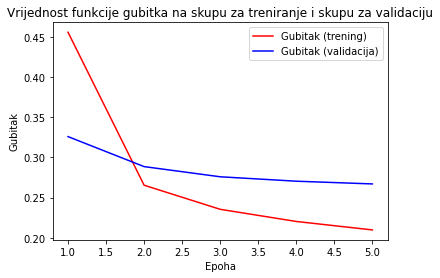

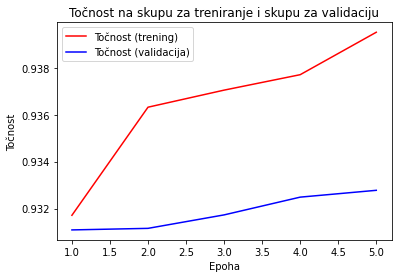

In [ ]:
plot_results(history_1)

Budući da nam se linije sve više počinju udaljavati, po tome možemo zaključiti da dolazi do blage pretreniranosti (overfittinga).

# Kreiranje funkcija za detaljnu evaluaciju modela

In [ ]:
# Predviđanja modela
model_1_pred_probs = model_1.predict(val_sentences_arrays_squeezed)
model_1_pred_probs.shape

(3249, 37, 9)

Gornji brojevi predstavljaju 3249 predikcija, 37 riječi po rečenici, te 9 mogućih oznaka (9 vjerojatnosti po riječi). Želimo za svaku riječ odrediti koja oznaka ima najveću vjerojatnost. Na kraju ćemo dobiti listu sa predviđenim oznakama.

In [ ]:
# Prva rečenica u skupu za validaciju
val_sentences_list[0]

'CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .'

In [ ]:
# Primjer predikcije za prvu riječ u gornjoj rečenici
model_1_pred_probs[0][0]

array([2.3282674e-04, 9.1323585e-05, 1.1926283e-03, 2.0160000e-03,
       3.2421795e-04, 2.8111623e-04, 1.1965941e-03, 1.9063608e-04,
       9.9447471e-01], dtype=float32)

In [ ]:
# Koji je indeks najveće vrijednosti?
np.argmax(model_1_pred_probs[0][0])

8

In [ ]:
# Koja je to oznaka?
idx2label[5]

'I-PER'

In [ ]:
# Koja je točna oznaka?
val_labels_padded[0][0]

8

In [ ]:
# Oblik točnih oznaka (3249 rečenice, 37 oznaka - jedna oznaka za svaku riječ)
val_labels_padded.shape

(3249, 37)

In [ ]:
# Kreiranje liste sa točnim oznakama
true_labels = []

for sentence in val_labels_padded:
  for label in sentence:
    true_labels.append(label)

# Prikaz prvih 10 točnih oznaka u skupu za validaciju
true_labels[:10]

[8, 8, 2, 8, 8, 8, 8, 8, 8, 8]

In [ ]:
# Funkcija koja prima vjerojatnosti (predviđanja modela) i vraća oznake sa najvećom vjerojatnosti
def get_labels_from_probs (pred_probs):
  
  predicted_labels = []

  for sentence in pred_probs:
    for label in sentence:
      predicted_labels.append(np.argmax(label)) # dodaj indeks oznake sa najvećom vjerojatnošću

  return predicted_labels

In [ ]:
model_1_predicted_labels = get_labels_from_probs(model_1_pred_probs)

# Prikaz prvih 10 predviđanja modela u skupu za validaciju
model_1_predicted_labels[:10]

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

Sada, nakon što imamo točne oznake i predviđene oznake u posebnim listama, možemo kreirati funkcije za detaljnu evaluaciju modela.

Prva funkcija prima listu sa točnim oznakama i predviđanja modela (vjerojatnosti), a vraća točnost (accuracy), preciznost, recall i F1-score.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results (y_true, pred_probs):
  
  y_pred = get_labels_from_probs(pred_probs)
  
  accuracy = accuracy_score(y_true, y_pred)

  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  
  results = {"accuracy": accuracy,
              "precision": precision,
              "recall": recall,
              "f1-score": f1}

  return results

# Primjer korištenja funkcije
model_1_results = calculate_results(true_labels, model_1_pred_probs)
model_1_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9327776529992596,
 'f1-score': 0.9079110727937507,
 'precision': 0.8907472253521749,
 'recall': 0.9327776529992596}

Sljedeća funkcija će kreirati detaljno tekstualno izvješće koje prikazuje metrike za svaku od oznaka.

### Classification report

In [ ]:
from sklearn.metrics import classification_report

def class_report (y_true, pred_probs, title):

  y_pred = get_labels_from_probs(pred_probs)

  print(f"\t\t\t-------------------\n\t\t\t{title}\n\t\t\t-------------------\n")
  print(classification_report(y_true, y_pred, target_names=list(idx2label.values())))

# Primjer korištenja funkcije
class_report(true_labels, model_1_pred_probs, "Rezultati modela 1")

			-------------------
			Rezultati modela 1
			-------------------

              precision    recall  f1-score   support

      B-MISC       0.00      0.00      0.00       890
       I-LOC       0.00      0.00      0.00       254
       B-ORG       0.32      0.21      0.25      1306
       B-LOC       0.00      0.00      0.00      1802
       I-ORG       0.50      0.00      0.01       724
       I-PER       0.30      0.09      0.14      1217
       B-PER       0.29      0.07      0.12      1721
      I-MISC       0.00      0.00      0.00       329
           O       0.94      1.00      0.97    111970

    accuracy                           0.93    120213
   macro avg       0.26      0.15      0.16    120213
weighted avg       0.89      0.93      0.91    120213



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Nastavak eksperimenata sa modelima

## Model 2 (LSTM treniran na tenzorima)

Koristimo istu arhitekturu kao i u prijašnjem modelu, jedina razlika je da ćemo ovaj put trenirati na tipu podatka `tf.Tensor` umjesto `np.array`.

In [ ]:
inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words, output_dim=50, input_length=37)(inputs)
x = layers.LSTM(100, return_sequences=True)(x)
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_2 = model_2.fit(
    x=data_50_percent_tensor,
    y=labels_50_percent_tensor,
    validation_data=(val_sentences_arrays_squeezed_tensors, # skup za validaciju moraju također biti tenzori
                     val_label_tensors), 
    epochs=5)

Epoch 1/5
220/220 [==============================] - 10s 38ms/step - loss: 0.4550 - accuracy: 0.9317 - val_loss: 0.3199 - val_accuracy: 0.9314
Epoch 2/5
220/220 [==============================] - 8s 35ms/step - loss: 0.2555 - accuracy: 0.9363 - val_loss: 0.2838 - val_accuracy: 0.9316
Epoch 3/5
220/220 [==============================] - 8s 35ms/step - loss: 0.2261 - accuracy: 0.9369 - val_loss: 0.2724 - val_accuracy: 0.9317
Epoch 4/5
220/220 [==============================] - 8s 35ms/step - loss: 0.2099 - accuracy: 0.9391 - val_loss: 0.2690 - val_accuracy: 0.9333
Epoch 5/5
220/220 [==============================] - 8s 35ms/step - loss: 0.1966 - accuracy: 0.9435 - val_loss: 0.2695 - val_accuracy: 0.9341


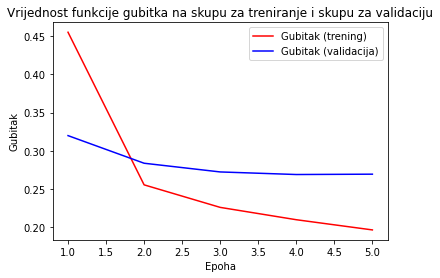

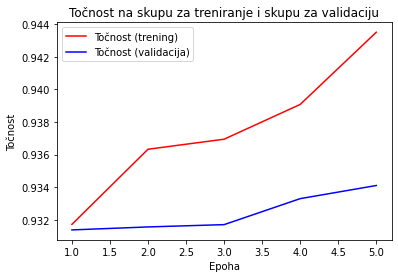

In [ ]:
plot_results(history_2)

Nema neke veće razlike između treniranja na NumPy arrayevima i na tenzorima. Zbog toga ćemo modele koji slijede trenirati samo na NumPy arrayevima.

In [ ]:
model_2_pred_probs = model_2.predict(val_sentences_arrays_squeezed)
model_2_results = calculate_results(true_labels, model_2_pred_probs)
model_2_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9341003052914411,
 'f1-score': 0.9102657208251921,
 'precision': 0.8978361100386051,
 'recall': 0.9341003052914411}

## Model 3 (smanjenje broja neurona, Dropout sloj)

U ovom modelu je cilj bio smanjiti overfitting na način da dodamo `Dropout` sloj koji nasumično "isključuje" određeni broj neurona u neuronskoj mreži te na taj način nastoji smanjiti pretreniranost mreže.

Također, smanjen je broj neurona u LSTM sloju sa 100 na 64 čime se smanjuje kompleksnost neuronske mreže.

In [ ]:
inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words,
                     output_dim=50,
                     input_length=37)(inputs)
x = layers.Dropout(0.3)(x) # dodan Dropout sloj
x = layers.LSTM(64, # 64 neurona umjesto 100
                return_sequences=True)(x)
outputs = layers.Dense(num_labels,
                       activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 37)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 37, 50)            1181150   
                                                                 
 dropout_1 (Dropout)         (None, 37, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 37, 64)            29440     
                                                                 
 dense_8 (Dense)             (None, 37, 9)             585       
                                                                 
Total params: 1,211,175
Trainable params: 1,211,175
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_3 = model_3.fit(
    x=data_50_percent_array,
    y=labels_50_percent_array,
    validation_data=(val_sentences_arrays_squeezed,
                     val_labels_padded), 
    epochs=5)

Epoch 1/5
220/220 [==============================] - 8s 30ms/step - loss: 0.5063 - accuracy: 0.9299 - val_loss: 0.3398 - val_accuracy: 0.9314
Epoch 2/5
220/220 [==============================] - 6s 28ms/step - loss: 0.2737 - accuracy: 0.9365 - val_loss: 0.2843 - val_accuracy: 0.9315
Epoch 3/5
220/220 [==============================] - 6s 28ms/step - loss: 0.2410 - accuracy: 0.9368 - val_loss: 0.2744 - val_accuracy: 0.9318
Epoch 4/5
220/220 [==============================] - 6s 28ms/step - loss: 0.2252 - accuracy: 0.9374 - val_loss: 0.2692 - val_accuracy: 0.9324
Epoch 5/5
220/220 [==============================] - 6s 28ms/step - loss: 0.2142 - accuracy: 0.9387 - val_loss: 0.2653 - val_accuracy: 0.9332


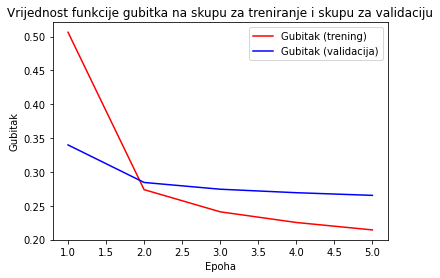

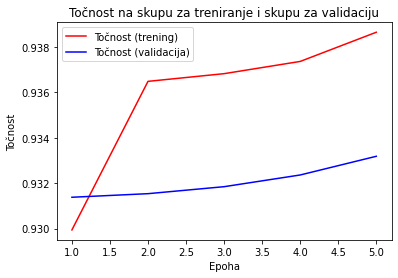

In [ ]:
plot_results(history_3)

Dodavanje dropout sloja i smanjenje broja neurona u LSTM sloju nije uspjelo smanjiti problem overfittinga.

In [ ]:
model_3_pred_probs = model_3.predict(val_sentences_arrays_squeezed)
model_3_results = calculate_results(true_labels, model_3_pred_probs)
model_3_results

{'accuracy': 0.933185262825152,
 'f1-score': 0.9061251692588117,
 'precision': 0.9086612020631244,
 'recall': 0.933185262825152}

## Model 4 (GRU sloj)

U ovom modelu je korištena druga vrsta sloja - `GRU` sloj. GRU je kratica za Gated Recurrent Unit te se ovaj sloj također koristi kod izgradnje arhitektura ponavljajućih neuronskih mreža.

GRU sloj funkcionira na sličan način kao i LSTM sloj, samo što ima manje parametara, što možemo vidjeti i u sažetku modela ispod.

In [ ]:
inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words, output_dim=50, input_length=37)(inputs)
x = layers.GRU(100, return_sequences=True)(x) # dodan GRU sloj
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_4 = tf.keras.Model(inputs, outputs)

model_4.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 37)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 37, 50)            1181150   
                                                                 
 gru_2 (GRU)                 (None, 37, 100)           45600     
                                                                 
 dense_9 (Dense)             (None, 37, 9)             909       
                                                                 
Total params: 1,227,659
Trainable params: 1,227,659
Non-trainable params: 0
_________________________________________________________________


Vidimo da GRU sloj ima samo oko 45.000 parametara, za razliku od LSTM slojeva koji su imali oko 60.000 parametara.

Epoch 1/5
220/220 [==============================] - 9s 34ms/step - loss: 0.4337 - accuracy: 0.9318 - val_loss: 0.2899 - val_accuracy: 0.9316
Epoch 2/5
220/220 [==============================] - 7s 32ms/step - loss: 0.2463 - accuracy: 0.9368 - val_loss: 0.2743 - val_accuracy: 0.9326
Epoch 3/5
220/220 [==============================] - 7s 32ms/step - loss: 0.2197 - accuracy: 0.9388 - val_loss: 0.2589 - val_accuracy: 0.9338
Epoch 4/5
220/220 [==============================] - 7s 32ms/step - loss: 0.1877 - accuracy: 0.9455 - val_loss: 0.2389 - val_accuracy: 0.9372
Epoch 5/5
220/220 [==============================] - 7s 32ms/step - loss: 0.1495 - accuracy: 0.9552 - val_loss: 0.2278 - val_accuracy: 0.9396


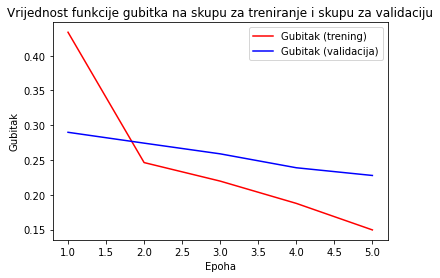

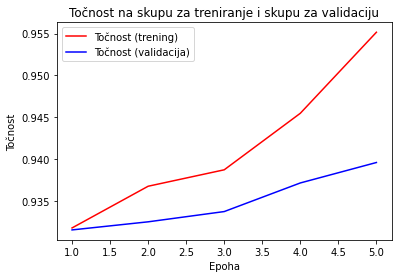

In [ ]:
model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_4 = model_4.fit(
    x=data_50_percent_array,
    y=labels_50_percent_array,
    validation_data=(val_sentences_arrays_squeezed,
                     val_labels_padded), 
    epochs=5)

plot_results(history_4)

Ovaj model ima višu točnost na skupu za validaciju od prvog, do sada najboljeg, modela. No i dalje vidimo izražen problem overfittinga.

In [ ]:
model_4_pred_probs = model_4.predict(val_sentences_arrays_squeezed)
model_4_results = calculate_results(true_labels, model_4_pred_probs)
model_4_results

{'accuracy': 0.9396238343606764,
 'f1-score': 0.9275593174407938,
 'precision': 0.9230979944985758,
 'recall': 0.9396238343606764}

In [ ]:
class_report(true_labels, model_4_pred_probs, "Rezultati modela 4")

			-------------------
			Rezultati modela 4
			-------------------

              precision    recall  f1-score   support

      B-MISC       0.52      0.26      0.35       890
       I-LOC       0.25      0.00      0.01       254
       B-ORG       0.60      0.35      0.44      1306
       B-LOC       0.57      0.29      0.38      1802
       I-ORG       0.42      0.24      0.30       724
       I-PER       0.45      0.25      0.32      1217
       B-PER       0.54      0.21      0.30      1721
      I-MISC       0.29      0.01      0.01       329
           O       0.95      0.99      0.97    111970

    accuracy                           0.94    120213
   macro avg       0.51      0.29      0.34    120213
weighted avg       0.92      0.94      0.93    120213



## Model 5 (GRU + AdamW optimizacijska funkcija)

U ovom modelu cilj je ponovno bio pokušati što više smanjiti overfitting.

Promjene su sljedeće:

* na GRU sloju dodani parametri `dropout=0.4` i `kernel_regularizer=l2(0.001)`
* promjena optimizacijske funkcije u `AdamW` (https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW)

`AdamW` je optimizacijska funkcija slična funkciji `Adam`, uz primjenu regularizacijske tehnike *weight decay* koja nastoji smanjiti overfitting. 

In [ ]:
!pip install tensorflow_addons # potrebno za AdamW optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Epoch 1/5
220/220 [==============================] - 16s 63ms/step - loss: 0.4779 - accuracy: 0.9312 - val_loss: 0.3167 - val_accuracy: 0.9315
Epoch 2/5
220/220 [==============================] - 14s 66ms/step - loss: 0.2706 - accuracy: 0.9365 - val_loss: 0.2913 - val_accuracy: 0.9317
Epoch 3/5
220/220 [==============================] - 8s 37ms/step - loss: 0.2471 - accuracy: 0.9366 - val_loss: 0.2803 - val_accuracy: 0.9315
Epoch 4/5
220/220 [==============================] - 8s 38ms/step - loss: 0.2330 - accuracy: 0.9370 - val_loss: 0.2761 - val_accuracy: 0.9321
Epoch 5/5
220/220 [==============================] - 8s 35ms/step - loss: 0.2197 - accuracy: 0.9398 - val_loss: 0.2662 - val_accuracy: 0.9340


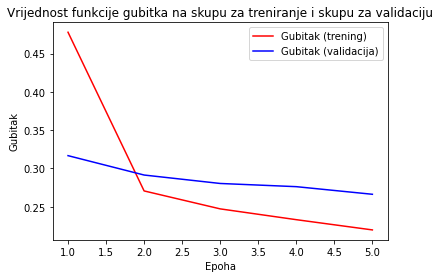

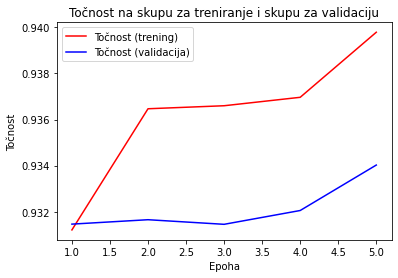

In [ ]:
import tensorflow_addons as tfa
from keras.regularizers import l2

# ovaj dio koda je preuzet sa https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([5000, 10000, 15000], [1e-1, 1e-2, 1e-3, 1e-4])
wd = lambda: 1e-4 * schedule(step)

inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words, output_dim=64, input_length=37)(inputs)
x = layers.GRU(100, return_sequences=True, dropout=0.4, kernel_regularizer=l2(0.001))(x) # dodani parametari 'dropout' i 'kernel_regularizer'
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(optimizer=tfa.optimizers.AdamW(weight_decay=wd), # promjena optimizacijske funkcije
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_5 = model_5.fit(
    x=data_50_percent_array,
    y=labels_50_percent_array,
    validation_data=(val_sentences_arrays_squeezed,
                     val_labels_padded), 
    epochs=5)

plot_results(history_5)

In [ ]:
model_5_pred_probs = model_5.predict(val_sentences_arrays_squeezed)
model_5_results = calculate_results(true_labels, model_5_pred_probs)
model_5_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9340254381805628,
 'f1-score': 0.9085352042987328,
 'precision': 0.9009032822610726,
 'recall': 0.9340254381805628}

In [ ]:
class_report(true_labels, model_5_pred_probs, "Rezultati modela 5")

			-------------------
			Rezultati modela 5
			-------------------

              precision    recall  f1-score   support

      B-MISC       0.12      0.01      0.01       890
       I-LOC       0.00      0.00      0.00       254
       B-ORG       0.44      0.19      0.26      1306
       B-LOC       0.63      0.02      0.04      1802
       I-ORG       0.08      0.01      0.02       724
       I-PER       0.36      0.10      0.15      1217
       B-PER       0.42      0.06      0.10      1721
      I-MISC       0.00      0.00      0.00       329
           O       0.94      1.00      0.97    111970

    accuracy                           0.93    120213
   macro avg       0.33      0.15      0.17    120213
weighted avg       0.90      0.93      0.91    120213



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 6 (bidirectional LSTM + AdamW)

U ovom modelu je kombinirana `AdamW` optimizacijska funkcija iz prošlog modela sa dvosmjernim LSTM slojem. Dvosmjerni (*Bidirectional*) sloj funkcionira kao omotač oko LSTM sloja i udvostručuje njegov broj parametara.

In [ ]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([5000, 10000, 15000], [1e-1, 1e-2, 1e-3, 1e-4])
wd = lambda: 1e-4 * schedule(step)

inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words, output_dim=64, input_length=37)(inputs)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.4, kernel_regularizer=l2(0.001), return_sequences=True))(x) # dodan bidirectional layer
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_6 = tf.keras.Model(inputs, outputs)

model_6.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 37)]              0         
                                                                 
 embedding_12 (Embedding)    (None, 37, 64)            1511872   
                                                                 
 bidirectional_1 (Bidirectio  (None, 37, 128)          66048     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 37, 9)             1161      
                                                                 
Total params: 1,579,081
Trainable params: 1,579,081
Non-trainable params: 0
_________________________________________________________________


LSTM sloj sa 64 neurona uobičajeno ima oko 30.000 parametara, a sada vidimo da ima oko 66.000 parametara zbog Bidirectional sloja.

Epoch 1/5
220/220 [==============================] - 25s 98ms/step - loss: 0.4839 - accuracy: 0.9284 - val_loss: 0.3309 - val_accuracy: 0.9314
Epoch 2/5
220/220 [==============================] - 12s 54ms/step - loss: 0.2824 - accuracy: 0.9364 - val_loss: 0.3005 - val_accuracy: 0.9313
Epoch 3/5
220/220 [==============================] - 10s 45ms/step - loss: 0.2569 - accuracy: 0.9364 - val_loss: 0.2882 - val_accuracy: 0.9312
Epoch 4/5
220/220 [==============================] - 10s 45ms/step - loss: 0.2420 - accuracy: 0.9363 - val_loss: 0.2812 - val_accuracy: 0.9310
Epoch 5/5
220/220 [==============================] - 10s 44ms/step - loss: 0.2306 - accuracy: 0.9363 - val_loss: 0.2762 - val_accuracy: 0.9305


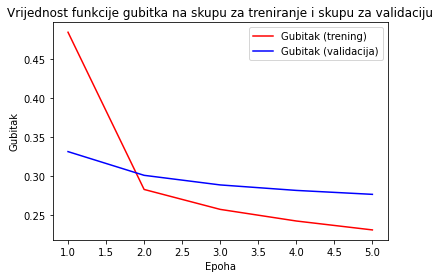

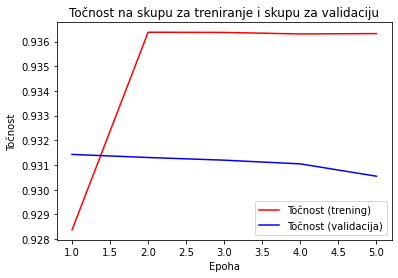

In [ ]:
model_6.compile(optimizer=tfa.optimizers.AdamW(weight_decay=wd),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_6 = model_6.fit(
    x=data_50_percent_array,
    y=labels_50_percent_array,
    validation_data=(val_sentences_arrays_squeezed,
                     val_labels_padded), 
    epochs=5)

plot_results(history_6)

Točnost na skupu za validaciju pada, što nije dobar znak.

In [ ]:
model_6_pred_probs = model_6.predict(val_sentences_arrays_squeezed)
model_6_results = calculate_results(true_labels, model_6_pred_probs)
model_6_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9305482768086646,
 'f1-score': 0.900035175071157,
 'precision': 0.8805852682760232,
 'recall': 0.9305482768086646}

## Model 7 (GRU + AdamW + Dropout slojevi)

Ovaj model je sličan modelu 5, uz par izmjena:

* dodana su 2 Dropout sloja
* promjena aktivacijske funkcije GRU sloja (iz defaultne `tanh` u `relu`)
* dodavanje parametra `kernel_initializer="he_normal"` u GRU sloj

Epoch 1/5
220/220 [==============================] - 10s 39ms/step - loss: 0.7586 - accuracy: 0.9290 - val_loss: 0.4302 - val_accuracy: 0.9314
Epoch 2/5
220/220 [==============================] - 8s 36ms/step - loss: 0.3345 - accuracy: 0.9364 - val_loss: 0.3168 - val_accuracy: 0.9314
Epoch 3/5
220/220 [==============================] - 8s 36ms/step - loss: 0.2663 - accuracy: 0.9364 - val_loss: 0.2844 - val_accuracy: 0.9315
Epoch 4/5
220/220 [==============================] - 8s 36ms/step - loss: 0.2387 - accuracy: 0.9372 - val_loss: 0.2707 - val_accuracy: 0.9332
Epoch 5/5
220/220 [==============================] - 8s 36ms/step - loss: 0.2216 - accuracy: 0.9406 - val_loss: 0.2578 - val_accuracy: 0.9364


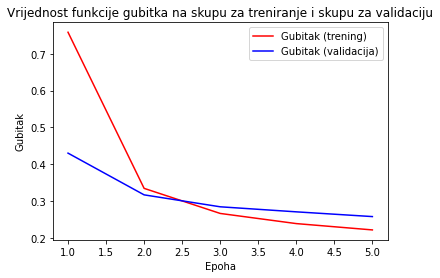

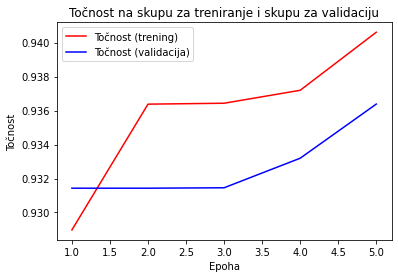

In [ ]:
import tensorflow_addons as tfa
from keras.regularizers import l2

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([5000, 10000, 15000], [1e-1, 1e-2, 1e-3, 1e-4])
wd = lambda: 1e-4 * schedule(step)

inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words, output_dim=64, input_length=37)(inputs)
x = layers.Dropout(0.2)(x) # dodan layer
x = layers.GRU(units=100,
               activation="relu", # dodano
               return_sequences=True,
               dropout=0.4,
               kernel_initializer="he_normal", # dodano
               kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.2)(x) # dodan layer
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_7 = tf.keras.Model(inputs, outputs)

model_7.compile(optimizer=tfa.optimizers.AdamW(weight_decay=wd),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_7 = model_7.fit(
    x=data_50_percent_array,
    y=labels_50_percent_array,
    validation_data=(val_sentences_arrays_squeezed,
                     val_labels_padded), 
    epochs=5)

plot_results(history_7)

Sa ovim modelom smo uspjeli djelomično smanjiti overfitting.

In [ ]:
model_7_pred_probs = model_7.predict(val_sentences_arrays_squeezed)
model_7_results = calculate_results(true_labels, model_7_pred_probs)
model_7_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9363795928892882,
 'f1-score': 0.912136276441244,
 'precision': 0.9029479109381799,
 'recall': 0.9363795928892882}

## Model 8 (bidirectional GRU + AdamW)

Ovaj model ima sličnu arhitekturu kao i prethodni model.

Promjene:

* GRU sloj zamijenjen sa Bidirectional GRU slojem
* dodan još jedan Dense sloj sa 64 neurona

Epoch 1/5
220/220 [==============================] - 18s 66ms/step - loss: 0.9451 - accuracy: 0.9281 - val_loss: 0.4905 - val_accuracy: 0.9314
Epoch 2/5
220/220 [==============================] - 14s 62ms/step - loss: 0.3448 - accuracy: 0.9364 - val_loss: 0.3078 - val_accuracy: 0.9314
Epoch 3/5
220/220 [==============================] - 14s 61ms/step - loss: 0.2494 - accuracy: 0.9366 - val_loss: 0.2797 - val_accuracy: 0.9318
Epoch 4/5
220/220 [==============================] - 14s 62ms/step - loss: 0.2201 - accuracy: 0.9407 - val_loss: 0.2638 - val_accuracy: 0.9357
Epoch 5/5
220/220 [==============================] - 14s 62ms/step - loss: 0.1919 - accuracy: 0.9467 - val_loss: 0.2476 - val_accuracy: 0.9379


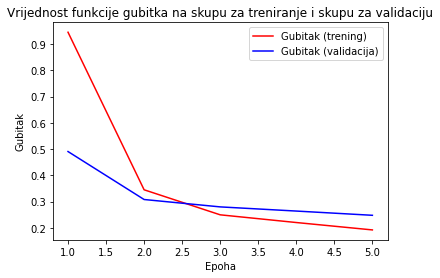

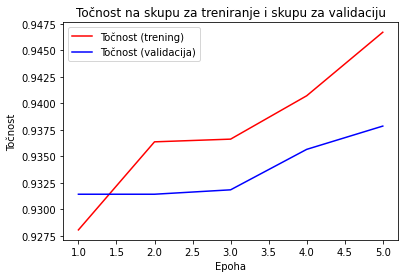

In [ ]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([5000, 10000, 15000], [1e-1, 1e-2, 1e-3, 1e-4])
wd = lambda: 1e-4 * schedule(step)

inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words, output_dim=64, input_length=37)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(layers.GRU(units=100,
                          activation="relu",
                          return_sequences=True,
                          dropout=0.4,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.001)))(x) # dodan Bidirectional
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x) # dodan layer
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_8 = tf.keras.Model(inputs, outputs)

model_8.compile(optimizer=tfa.optimizers.AdamW(weight_decay=wd),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_8 = model_8.fit(
    x=data_50_percent_array,
    y=labels_50_percent_array,
    validation_data=(val_sentences_arrays_squeezed,
                     val_labels_padded), 
    epochs=5)

plot_results(history_8)

In [ ]:
model_8_pred_probs = model_8.predict(val_sentences_arrays_squeezed)
model_8_results = calculate_results(true_labels, model_8_pred_probs)
model_8_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9378602979711013,
 'f1-score': 0.920157207395321,
 'precision': 0.911683160576041,
 'recall': 0.9378602979711013}

## Model 9 (birectional GRU + AdamW sa LRS)

Model 9 je isti kao i model 8, osim što je dodan Learning Rate Scheduler (kod preuzet sa dokumentacije TensorFlow-a: https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW).

Također, u arhitekturu mreže dodan je još jedan Dropout layer.

Epoch 1/5
220/220 [==============================] - 17s 64ms/step - loss: 0.3972 - accuracy: 0.9325 - val_loss: 0.3239 - val_accuracy: 0.9333
Epoch 2/5
220/220 [==============================] - 14s 63ms/step - loss: 0.2545 - accuracy: 0.9406 - val_loss: 0.2577 - val_accuracy: 0.9371
Epoch 3/5
220/220 [==============================] - 14s 63ms/step - loss: 0.2028 - accuracy: 0.9470 - val_loss: 0.2312 - val_accuracy: 0.9419
Epoch 4/5
220/220 [==============================] - 15s 68ms/step - loss: 0.1743 - accuracy: 0.9525 - val_loss: 0.2391 - val_accuracy: 0.9432
Epoch 5/5
220/220 [==============================] - 14s 63ms/step - loss: 0.1597 - accuracy: 0.9563 - val_loss: 0.2268 - val_accuracy: 0.9447


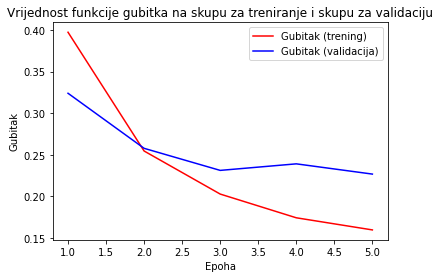

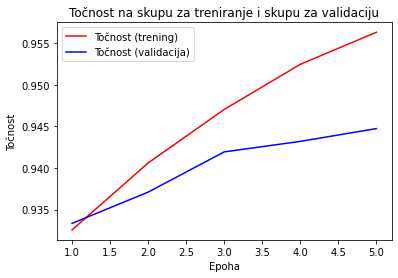

In [ ]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([5000, 10000, 15000], [1e-1, 1e-2, 1e-3, 1e-4])
lr = 1e-1 * schedule(step) # dodano
wd = lambda: 1e-4 * schedule(step)

inputs = tf.keras.Input(shape=(37,))
x = layers.Embedding(input_dim=num_words, output_dim=64, input_length=37)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(layers.GRU(units=100,
                          activation="relu",
                          return_sequences=True,
                          dropout=0.4,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.001)))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.4)(x) # dodan dropout
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_9 = tf.keras.Model(inputs, outputs)

model_9.compile(optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd), # promjena
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_9 = model_9.fit(
    x=data_50_percent_array,
    y=labels_50_percent_array,
    validation_data=(val_sentences_arrays_squeezed,
                     val_labels_padded), 
    epochs=5)

plot_results(history_9)

In [ ]:
model_9_pred_probs = model_9.predict(val_sentences_arrays_squeezed)
model_9_results = calculate_results(true_labels, model_9_pred_probs)
model_9_results

{'accuracy': 0.9447397536040195,
 'f1-score': 0.9323524164392734,
 'precision': 0.9335552550266388,
 'recall': 0.9447397536040195}

Sa ovim modelom smo dobili najvišu točnost na skupu za validaciju dosad.

# Drugi način pripreme podataka

Pokušati ćemo povećati duljinu ulaznih podataka sa 37 na 50 i usporediti rezultate sa prijašnjim modelima.

In [ ]:
# Što ako povećamo duljinu rečenica sa 37 riječi na 50?

from tensorflow.keras.layers import TextVectorization

text_vectorizer_50 = TextVectorization(max_tokens=23000,
                                       output_sequence_length=50)

In [ ]:
text_vectorizer_50.adapt(train_sentences_list)

In [ ]:
# Ponovna vektorizacija svih rečenica
train_sentences_vectorized_50 = [text_vectorizer_50([x]) for x in train_sentences_list]
val_sentences_vectorized_50 = [text_vectorizer_50([x]) for x in val_sentences_list]
test_sentences_vectorized_50 = [text_vectorizer_50([x]) for x in test_sentences_list]

In [ ]:
# Oznake trenutno imaju duljinu pripadajućih rečenica
train_labels_tokenized[0]

[2, 8, 0, 8, 8, 8, 0, 8, 8]

In [ ]:
# Padding oznaka

train_labels_padded_50 = pad_sequences(maxlen=50, # 50 umjesto 37
                                        sequences=train_labels_tokenized,
                                        padding="post",
                                        value=label2idx["O"])

val_labels_padded_50 = pad_sequences(maxlen=50,
                                      sequences=val_labels_tokenized,
                                      padding="post",
                                      value=label2idx["O"])

test_labels_padded_50 = pad_sequences(maxlen=50,
                                      sequences=test_labels_tokenized,
                                      padding="post",
                                      value=label2idx["O"])

In [ ]:
# Pretvaranje rečenica u NumPy arrayove
import numpy as np
train_sentences_arrays_50 = [np.array(t) for t in train_sentences_vectorized_50]
val_sentences_arrays_50 = [np.array(t) for t in val_sentences_vectorized_50]
test_sentences_arrays_50 = [np.array(t) for t in test_sentences_vectorized_50]

In [ ]:
# Smanjivanje dimenzionalosti rečenica - iz (1, 50) u (50,)
train_sentences = np.squeeze(train_sentences_arrays_50)
val_sentences = np.squeeze(val_sentences_arrays_50)
test_sentences = np.squeeze(test_sentences_arrays_50)

In [ ]:
type(train_sentences[0]), type(train_labels_padded_50[0])

(numpy.ndarray, numpy.ndarray)

In [ ]:
print(f"Oblik rečenica (tipa NumPy array): {train_sentences.shape}")
print(f"Oblik oznaka (tipa NumPy array): {train_labels_padded_50.shape}")

Oblik rečenica (tipa NumPy array): (14040, 50)
Oblik oznaka (tipa NumPy array): (14040, 50)


## Model 10 (dulje rečenice)

In [ ]:
# Treniramo samo na 50% podataka

X_train, X_50_percent, y_train, y_50_percent = train_test_split(train_sentences,
                                                                train_labels_padded_50,
                                                                test_size=0.5,
                                                                random_state=42)

In [ ]:
X_50_percent.shape, y_50_percent.shape

((7020, 50), (7020, 50))

In [ ]:
num_words

23623

Epoch 1/5
220/220 [==============================] - 12s 45ms/step - loss: 0.3716 - accuracy: 0.9474 - val_loss: 0.2431 - val_accuracy: 0.9474
Epoch 2/5
220/220 [==============================] - 10s 44ms/step - loss: 0.1970 - accuracy: 0.9519 - val_loss: 0.2115 - val_accuracy: 0.9480
Epoch 3/5
220/220 [==============================] - 10s 44ms/step - loss: 0.1716 - accuracy: 0.9523 - val_loss: 0.2019 - val_accuracy: 0.9482
Epoch 4/5
220/220 [==============================] - 10s 46ms/step - loss: 0.1586 - accuracy: 0.9533 - val_loss: 0.1970 - val_accuracy: 0.9485
Epoch 5/5
220/220 [==============================] - 10s 44ms/step - loss: 0.1490 - accuracy: 0.9555 - val_loss: 0.1929 - val_accuracy: 0.9493


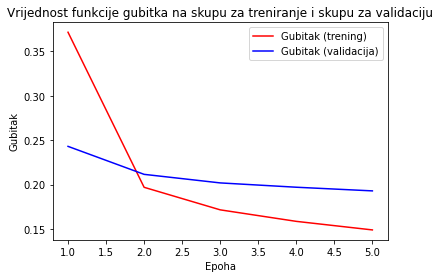

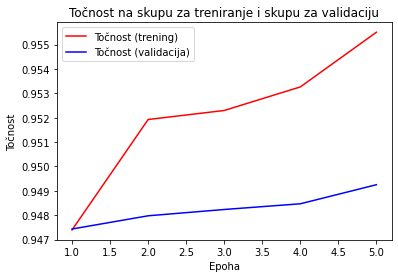

In [ ]:
# Ista arhitektura kao model_1

inputs = tf.keras.Input(shape=(50,)) # input shape je sada 50
x = layers.Embedding(input_dim=23000, output_dim=50, input_length=50)(inputs)
x = layers.LSTM(100, return_sequences=True)(x)
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_10 = tf.keras.Model(inputs, outputs)

model_10.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

history_10 = model_10.fit(X_50_percent,
                          y_50_percent,
                          validation_data=(val_sentences,
                                          val_labels_padded_50), 
                          epochs=5)

plot_results(history_10)

In [ ]:
# Kreiranje liste sa točnim oznakama
true_labels_50 = []

for sentence in val_labels_padded_50:
  for label in sentence:
    true_labels_50.append(label)

In [ ]:
model_10_pred_probs = model_10.predict(val_sentences)
model_10_results = calculate_results(true_labels_50, model_10_pred_probs)
model_10_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9492520775623269,
 'f1-score': 0.9313414052692007,
 'precision': 0.9183136071541865,
 'recall': 0.9492520775623269}

In [ ]:
# Usporedba sa prvim modelom
model_1_results

{'accuracy': 0.9327776529992596,
 'f1-score': 0.9079110727937507,
 'precision': 0.8907472253521749,
 'recall': 0.9327776529992596}

Model 10 ima bolji metrike od modela 1. Što ako uzmemo najbolji model koji smo imali s rečenicama duljine 37 i istreniramo ga na rečenicama duljine 50?

## Model 11 (isti kao model 9, ali sa duljim rečenicama)

Epoch 1/5
220/220 [==============================] - 20s 80ms/step - loss: 0.2904 - accuracy: 0.9477 - val_loss: 0.2042 - val_accuracy: 0.9483
Epoch 2/5
220/220 [==============================] - 17s 77ms/step - loss: 0.1685 - accuracy: 0.9541 - val_loss: 0.1831 - val_accuracy: 0.9510
Epoch 3/5
220/220 [==============================] - 17s 77ms/step - loss: 0.1447 - accuracy: 0.9600 - val_loss: 0.1756 - val_accuracy: 0.9554
Epoch 4/5
220/220 [==============================] - 17s 77ms/step - loss: 0.1260 - accuracy: 0.9655 - val_loss: 0.1710 - val_accuracy: 0.9569
Epoch 5/5
220/220 [==============================] - 17s 77ms/step - loss: 0.1153 - accuracy: 0.9686 - val_loss: 0.1622 - val_accuracy: 0.9580


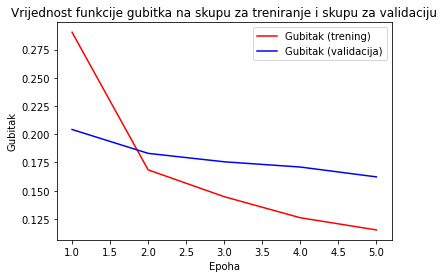

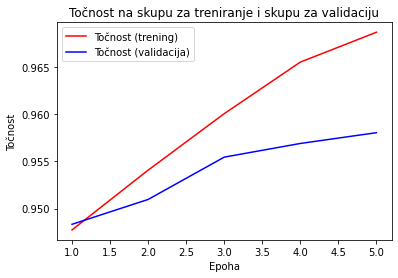

In [ ]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([5000, 10000, 15000], [1e-1, 1e-2, 1e-3, 1e-4])
lr = 1e-1 * schedule(step)
wd = lambda: 1e-4 * schedule(step)

inputs = tf.keras.Input(shape=(50,)) # input shape je sada 50
x = layers.Embedding(input_dim=num_words, output_dim=64, input_length=37)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(layers.GRU(units=100,
                          activation="relu",
                          return_sequences=True,
                          dropout=0.4,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.001)))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_11 = tf.keras.Model(inputs, outputs)

model_11.compile(optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

history_11 = model_11.fit(X_50_percent,
                          y_50_percent,
                          validation_data=(val_sentences,
                                          val_labels_padded_50), 
                          epochs=5)

plot_results(history_11)

In [ ]:
model_11_pred_probs = model_11.predict(val_sentences)
model_11_results = calculate_results(true_labels_50, model_11_pred_probs)
model_11_results

{'accuracy': 0.9580240073868883,
 'f1-score': 0.9505383436644911,
 'precision': 0.9498855046417278,
 'recall': 0.9580240073868883}

In [ ]:
# Usporedba sa modelom 9
model_9_results

{'accuracy': 0.9447397536040195,
 'f1-score': 0.9323524164392734,
 'precision': 0.9335552550266388,
 'recall': 0.9447397536040195}

Model 11 je model sa najboljim rezultatima dosad, pa sam odlučio njega upotrijebiti u konačnoj verziji projekta. U donjoj ćeliji može se vidjeti detaljno izvješće klasifikacije.

In [ ]:
class_report(true_labels_50, model_11_pred_probs, "Rezultati modela 11")

			-------------------
			Rezultati modela 11
			-------------------

              precision    recall  f1-score   support

      B-MISC       0.51      0.40      0.45       918
       I-LOC       0.71      0.16      0.27       255
       B-ORG       0.72      0.39      0.51      1340
       B-LOC       0.63      0.39      0.48      1830
       I-ORG       0.63      0.31      0.41       750
       I-PER       0.63      0.26      0.37      1257
       B-PER       0.58      0.27      0.37      1793
      I-MISC       0.82      0.04      0.08       339
           O       0.97      0.99      0.98    153968

    accuracy                           0.96    162450
   macro avg       0.69      0.36      0.44    162450
weighted avg       0.95      0.96      0.95    162450



# Usporedba rezultata svih modela

In [ ]:
import pandas as pd

all_model_results = pd.DataFrame({"model_1": model_1_results,
                                  "model_2": model_2_results,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  "model_5": model_5_results,
                                  "model_6": model_6_results,
                                  "model_7": model_7_results,
                                  "model_8": model_8_results,
                                  "model_9": model_9_results,
                                  "model_10": model_10_results,
                                  "model_11": model_11_results})

In [ ]:
# Sortirano po f1-scoreu
all_model_results.transpose().sort_values(by="f1-score", ascending=False)

,accuracy,precision,recall,f1-score
model_11,0.958024,0.949886,0.958024,0.950538
model_9,0.944740,0.933555,0.944740,0.932352
model_10,0.949252,0.918314,0.949252,0.931341
model_4,0.939624,0.923098,0.939624,0.927559
model_8,0.937860,0.911683,0.937860,0.920157
model_7,0.936380,0.902948,0.936380,0.912136
model_2,0.934100,0.897836,0.934100,0.910266
model_5,0.934025,0.900903,0.934025,0.908535
model_1,0.932778,0.890747,0.932778,0.907911
model_3,0.933185,0.908661,0.933185,0.906125
